In [54]:
import sys
print(sys.executable)
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

/usr/local/bin/python3.11


In [55]:
import numpy as np

def get_F(dt: float) -> np.ndarray:
    F = np.eye(6)
    F[0, 1] = dt
    F[2, 3] = dt 
    F[4, 5] = dt 
    return F

def get_G(dt: float) -> np.ndarray:
    G = np.zeros((6, 3))
    G[0, 0] = 0.5 * dt**2
    G[1, 0] = dt
    G[2, 1] = 0.5 * dt**2
    G[3, 1] = dt
    G[4, 2] = 0.5 * dt**2
    G[5, 2] = dt
    return G

def get_Q(dt: float, sigma_a: float) -> np.ndarray:
    dt2 = dt**2
    dt3 = dt**3
    dt4 = dt**4

    A = np.array([[dt4/4.0, dt3/2.0],
                  [dt3/2.0, dt2     ]]) * (sigma_a**2)

    Q = np.zeros((6, 6))
    for i in range(3):
        Q[2*i:2*i+2, 2*i:2*i+2] = A
    return Q

def obs_matrix(x: np.ndarray) -> np.ndarray:
    px, vx, py, vy, pz, vz = x
    d = np.sqrt(px**2 + py**2 + pz**2)
    return np.array([d])

def obs_jacobian(x: np.ndarray) -> np.ndarray:
    px, vx, py, vy, pz, vz = x
    r = np.sqrt(px**2 + py**2 + pz**2) + 1e-12
    H = np.array([[px/r, 0.0,
                   py/r, 0.0,
                   pz/r, 0.0]])
    return H

def predict_step(x: np.ndarray,
                 P: np.ndarray,
                 a_world: np.ndarray,
                 dt: float,
                 sigma_a: float) -> tuple[np.ndarray, np.ndarray]:
    F = get_F(dt)
    G = get_G(dt)
    Q = get_Q(dt, sigma_a)

    x_pred = F @ x + G @ a_world
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred

def update_step(x_pred: np.ndarray,
                P_pred: np.ndarray,
                z: float,
                sigma_d: float) -> tuple[np.ndarray, np.ndarray]:
    h = obs_matrix(x_pred)
    H = obs_jacobian(x_pred)

    y = z - h[0]

    S = (H @ P_pred @ H.T)[0, 0] + sigma_d**2

    K = (P_pred @ H.T) / S

    x_upd = x_pred + (K * y).ravel()
    I = np.eye(6)
    P_upd = (I - K @ H) @ P_pred

    return x_upd, P_upd

def run_ekf(accel_world, range_meas, dt,
            x0, P0, sigma_a, sigma_d):
    N = len(range_meas)
    x = x0.astype(float).copy()
    P = P0.astype(float).copy()
    x_hist = np.zeros((N, 6))
    d_pred = np.zeros(N)
    for k in range(N):
        a_k = accel_world[k]
        x_pred, P_pred = predict_step(x, P, a_k, dt, sigma_a)
        x, P = update_step(x_pred, P_pred, range_meas[k], sigma_d)
        x_hist[k] = x
        d_pred[k] = obs_matrix(x)[0]
    return x_hist, d_pred

def radial_constraint_update(x: np.ndarray,
                             P: np.ndarray,
                             sigma_c: float) -> tuple[np.ndarray, np.ndarray]:
    px, vx, py, vy, pz, vz = x
    r = np.sqrt(px**2 + py**2 + pz**2)
    if r < 1e-8:
        return x, P

    rv = px*vx + py*vy + pz*vz
    h = rv / r

    dh_dpx = vx / r - rv * px / r**3
    dh_dpy = vy / r - rv * py / r**3
    dh_dpz = vz / r - rv * pz / r**3

    dh_dvx = px / r
    dh_dvy = py / r
    dh_dvz = pz / r

    Hc = np.array([[dh_dpx, dh_dvx,
                    dh_dpy, dh_dvy,
                    dh_dpz, dh_dvz]])

    zc = 0.0
    yc = zc - h

    Sc = (Hc @ P @ Hc.T)[0, 0] + sigma_c**2
    Kc = (P @ Hc.T) / Sc

    x_new = x + (Kc * yc).ravel()
    I = np.eye(6)
    P_new = (I - Kc @ Hc) @ P

    return x_new, P_new

def run_ekf_with_constraint(accel_world, range_meas, dt,
                            x0, P0,
                            sigma_a, sigma_d,
                            sigma_c, dsdt_thresh):
    N = len(range_meas)
    x = x0.astype(float).copy()
    P = P0.astype(float).copy()
    x_hist = np.zeros((N, 6))
    d_pred = np.zeros(N)

    prev_d = range_meas[0]
    for k in range(N):
        a_k = accel_world[k]
        x_pred, P_pred = predict_step(x, P, a_k, dt, sigma_a)
        x, P = update_step(x_pred, P_pred, range_meas[k], sigma_d)

        if k > 0:
            dsdt_meas = (range_meas[k] - prev_d) / dt
            if abs(dsdt_meas) < dsdt_thresh:
                x, P = radial_constraint_update(x, P, sigma_c)
            prev_d = range_meas[k]

        x_hist[k] = x
        d_pred[k] = obs_matrix(x)[0]

    return x_hist, d_pred

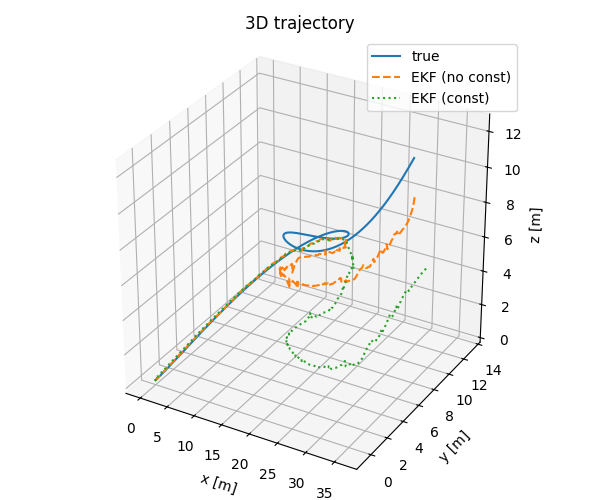

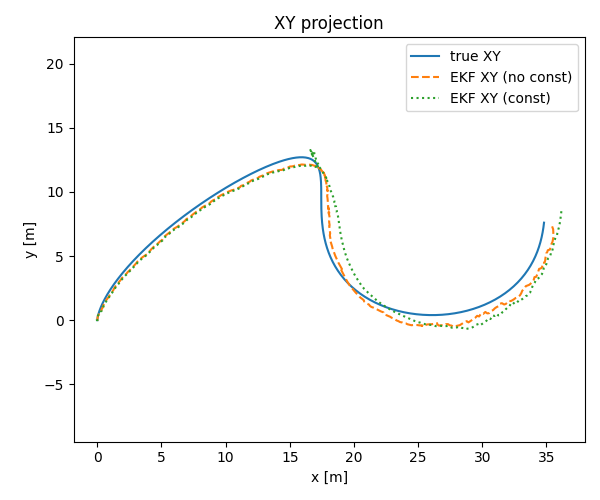

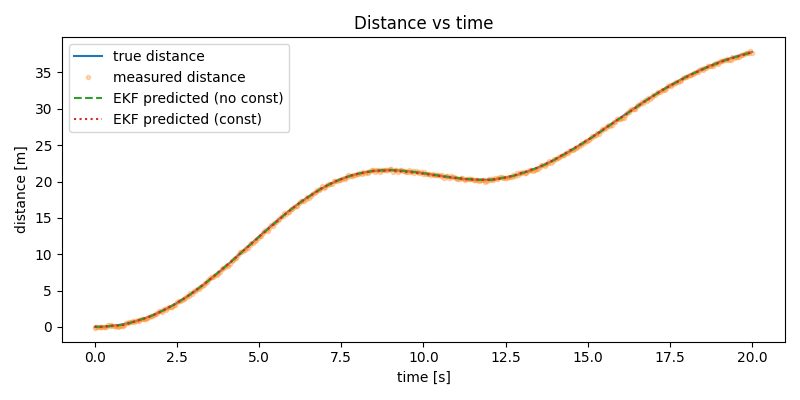

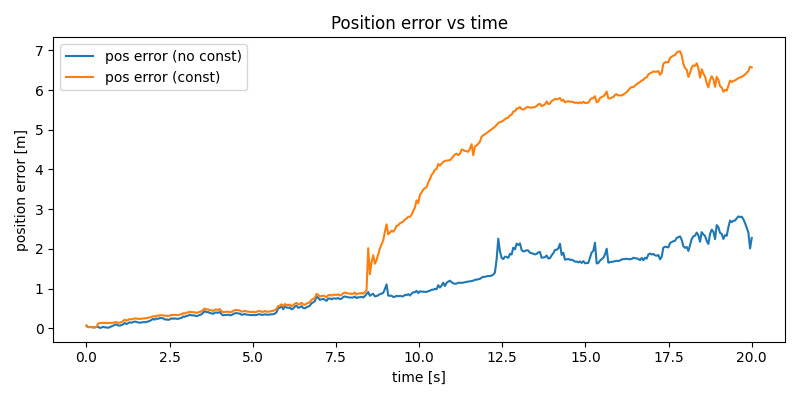

In [56]:
import numpy as np
import matplotlib.pyplot as plt

T = 20.0
N = 400
t = np.linspace(0, T, N)
dt = T / (N - 1)

a_x = np.sin(0.6 * t)
a_y = np.cos(0.4 * t)
a_z = 0.5 * np.sin(0.8 * t)
a_true = np.stack([a_x, a_y, a_z], axis=1)

p_true = np.zeros((N, 3))
v_true = np.zeros((N, 3))

for k in range(1, N):
    a_km1 = a_true[k-1]
    p_true[k] = p_true[k-1] + v_true[k-1] * dt + 0.5 * a_km1 * dt**2
    v_true[k] = v_true[k-1] + a_km1 * dt

d_true = np.linalg.norm(p_true, axis=1)

rng = np.random.default_rng(42)

sigma_a = 0.2
sigma_d = 0.1

a_meas = a_true + rng.normal(0, sigma_a, size=a_true.shape)
d_meas = d_true + rng.normal(0, sigma_d, size=d_true.shape)

x0 = np.zeros(6)
P0 = np.eye(6) * 0.01

x_hist_nc, d_pred_nc = run_ekf(a_meas, d_meas, dt, x0, P0, sigma_a, sigma_d)
p_est_nc = x_hist_nc[:, [0, 2, 4]]

sigma_c = 0.05
dsdt_thresh = 0.02

x_hist_c, d_pred_c = run_ekf_with_constraint(
    a_meas, d_meas, dt,
    x0, P0,
    sigma_a, sigma_d,
    sigma_c, dsdt_thresh
)
p_est_c = x_hist_c[:, [0, 2, 4]]

pos_err_nc = np.linalg.norm(p_est_nc - p_true, axis=1)
pos_err_c  = np.linalg.norm(p_est_c  - p_true, axis=1)

rmse_nc = np.sqrt(np.mean(pos_err_nc**2))
rmse_c  = np.sqrt(np.mean(pos_err_c**2))

d_est_nc = np.linalg.norm(p_est_nc, axis=1)
d_est_c  = np.linalg.norm(p_est_c,  axis=1)
rmse_d_nc = np.sqrt(np.mean((d_est_nc - d_true)**2))
rmse_d_c  = np.sqrt(np.mean((d_est_c  - d_true)**2))


fig1 = plt.figure(figsize=(6, 5))
ax3d = fig1.add_subplot(111, projection='3d')
ax3d.plot(p_true[:, 0], p_true[:, 1], p_true[:, 2], label="true")
ax3d.plot(p_est_nc[:, 0], p_est_nc[:, 1], p_est_nc[:, 2], "--", label="EKF (no const)")
ax3d.plot(p_est_c[:, 0],  p_est_c[:, 1],  p_est_c[:, 2],  ":", label="EKF (const)")
ax3d.set_xlabel("x [m]")
ax3d.set_ylabel("y [m]")
ax3d.set_zlabel("z [m]")
ax3d.set_title("3D trajectory")
ax3d.legend()
ax3d.set_box_aspect([1, 1, 1])
fig1.tight_layout()
plt.show()

fig2, ax_xy = plt.subplots(figsize=(6, 5))
ax_xy.plot(p_true[:, 0], p_true[:, 1], label="true XY")
ax_xy.plot(p_est_nc[:, 0], p_est_nc[:, 1], "--", label="EKF XY (no const)")
ax_xy.plot(p_est_c[:, 0],  p_est_c[:, 1],  ":", label="EKF XY (const)")
ax_xy.set_xlabel("x [m]")
ax_xy.set_ylabel("y [m]")
ax_xy.set_title("XY projection")
ax_xy.axis("equal")
ax_xy.legend()
fig2.tight_layout()
plt.show()

fig3, ax_d = plt.subplots(figsize=(8, 4))
ax_d.plot(t, d_true, label="true distance")
ax_d.plot(t, d_meas, ".", alpha=0.3, label="measured distance")
ax_d.plot(t, d_pred_nc, "--", label="EKF predicted (no const)")
ax_d.plot(t, d_pred_c,  ":", label="EKF predicted (const)")
ax_d.set_xlabel("time [s]")
ax_d.set_ylabel("distance [m]")
ax_d.set_title("Distance vs time")
ax_d.legend()
fig3.tight_layout()
plt.show()

fig4, ax_err = plt.subplots(figsize=(8, 4))
ax_err.plot(t, pos_err_nc, label="pos error (no const)")
ax_err.plot(t, pos_err_c,  label="pos error (const)")
ax_err.set_xlabel("time [s]")
ax_err.set_ylabel("position error [m]")
ax_err.set_title("Position error vs time")
ax_err.legend()
fig4.tight_layout()
plt.show()


In [7]:
x_n = np.array([0,0,0,0,0,0])
P_n = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [8]:
def predict_state(F, X):
    prediction_state = F @ X
    return prediction_state

def predict_cov(F, P, Q):
    prediction_cov = F @ P @ F.T + Q
    return prediction_cov

In [9]:
measurement = np.array([0])

In [10]:
def obs_matrix(X):
    hx = np.array([np.sqrt(X[0] ** 2 + X[2] ** 2 + X[4] ** 2)])
    return hx

In [11]:
def obs_jacobian(X):
    dist = np.sqrt(X[0] ** 2 + X[2] ** 2 + X[4] ** 2)
    partial_hx = np.array([X[0]]/dist, 0, X[2]/dist, 0, X[4]/dist, 0)
    return partial_hx


In [12]:
def kalman_gain(P, partial_hx, R):
    Kn = P @ partial_hx.T @ np.inv(partial_hx @ P @ partial_hx.T + R)
    return Kn

In [13]:
def current_state_estimate(X, Kn, zn, hx):
    return X + Kn @ (zn - hx)

In [14]:
def get_Q(dt, epsilon):
    Q = np.zeros((6,6))
    A = np.array([[(dt ** 4)/4, (dt ** 3) / 2],
                  [(dt ** 3)/2, dt ** 2]])
    for i in range(3):
        Q[2*i:2*i + 2, 2*i:2*i + 2] = A
    Q *= (epsilon ** 2)
    return Q

def initialize_P(var):
    return np.eye(6) * var

def get_F(dt):
    F = np.zeros((6,6))
    A = np.array([[1, dt],
                  [0, 1]])
    for i in range(3):
        F[2*i:2*i+2, 2*i:2*i+2] = A
    return F

In [15]:
def EKF(x0, P0, epsilon, R, data): #accel data: data[0], dist data: data[1]
    x_current = x0
    P_current = P0
    ret_data = np.array([])
    for idx, item in enumerate(data):
        if idx != 0:
            zn = item[4][idx]
            hx = obs_matrix(x_pred)
            jacobian = obs_jacobian(x_pred)
            Kn = kalman_gain(P_pred, jacobian, R)
            x_current = current_state_estimate(x_pred, Kn, zn, hx)
            print(x_current)
            P_current = (np.identity(6) - Kn @ jacobian) @ P_pred @ (np.identity(6) - Kn @ jacobian).T + Kn @ R @ Kn.T
        F = get_F(data[5, idx])
        x_pred = predict_state(F, x_current)
        Q = get_Q(data[5, idx], epsilon)
        P_pred = predict_cov(F, P_current, Q)
        ret_data.append(x_current)
    return ret_data

In [16]:
t = np.linspace(0, 10, 100)  # 10 seconds sampled at 100 points
dt = np.diff(t)
dt = np.append(dt, dt[-1])

# Acceleration data
a_x = np.linspace(0, 2 * np.pi, 100)
a_y = np.linspace(0, 2 * np.pi, 100)
a_z = np.sin(np.linspace(0, 2 * np.pi, 100))

# Integrate acceleration to get velocity
v_x = cumulative_trapezoid(a_x, t, initial=0)
v_y = cumulative_trapezoid(a_y, t, initial=0)
v_z = cumulative_trapezoid(a_z, t, initial=0)

# Integrate velocity to get position
p_x = cumulative_trapezoid(v_x, t, initial=0)
p_y = cumulative_trapezoid(v_y, t, initial=0)
p_z = cumulative_trapezoid(v_z, t, initial=0)

# Compute distance from origin at each time step
distance = np.sqrt(p_x**2 + p_y**2 + p_z**2)
print(np.size(distance))

# Stack them horizontally: each row is [x, y, z, distance]
data = np.vstack((a_x, a_y, a_z, distance, dt))

100


In [ ]:
x0 = np.array([0,0,0,0,0,0])
P0 = np.eye(6) * 5
R = np.array([0.1])

TypeError: EKF() missing 3 required positional arguments: 'epsilon', 'R', and 'data'

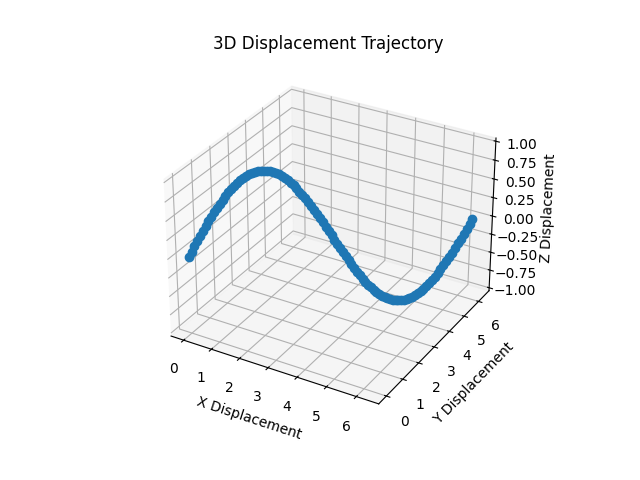

In [18]:
# Run this at the top of your notebook
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create interactive plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D trajectory
ax.plot(data[0], data[1], data[2], marker='o')

# Set axis labels and title
ax.set_xlabel('X Displacement')
ax.set_ylabel('Y Displacement')
ax.set_zlabel('Z Displacement')
ax.set_title('3D Displacement Trajectory')

plt.show()